In [1]:
import networkx as nx
import matplotlib.pyplot as plt
#from matplotlib.colorbar import constrained_layout
import numpy as np
import scipy
from scipy.linalg import cholesky
from sklearn.metrics.cluster import normalized_mutual_info_score
from networkx.algorithms.community import greedy_modularity_communities
import cvxpy
import pandas as pd
import os
from networkx.algorithms.community import kernighan_lin_bisection
from numpy import linalg as LA

In [2]:
#空手クラブ
G = nx.karate_club_graph()
#レ・ミゼラブル
#G = nx.les_miserables_graph()
#dolphins
#G = nx.read_gml("dolphins.gml")
#LFR Benchmarkグラフ(6, )
#seed_raw = np.arange(1,100)
#nodes = 1000
#G = nx.LFR_benchmark_graph(nodes, 2, 1.5, 0.1, average_degree=10, max_degree=int(nodes/10), min_community=50, max_community=int(nodes/10))
#G = nx.LFR_benchmark_graph(50, 2, 1.5, 0.1, average_degree=3, max_degree=50, min_community=50)
#G = nx.LFR_benchmark_graph(100, 2, 1.1, 0.1, average_degree=15, max_degree=50, min_community=10, max_community=100)
#G = nx.LFR_benchmark_graph(50, 5, 1.5, 0.1, average_degree=10, min_community=20, max_community=50)
#G = nx.LFR_benchmark_graph(100, 3, 1.5, 0.1, average_degree=5, min_community=20)
#簡易グラフ
#G = nx.Graph()
#G.add_nodes_from([1, 2, 3, 4, 5, 6])
#G.add_edges_from([(1, 2), (1, 3), (2, 3), (1, 4), (4, 5), (4, 6), (5, 6)])
#G = nx.planted_partition_graph(2, 50, 0.8, 0.6, seed=1)


colors = ['red', 'blue', 'green', 'yellow', 'pink', 'crimson', 'orange']
pos = nx.spring_layout(G)

np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#print(nx.adjacency_matrix(G).todense())
print(G.nodes())
print(G.edges())
print('次数：', G.degree())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 2), (1, 3), (1, 7), (1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (2, 3), (2, 7), (2, 8), (2, 9), (2, 13), (2, 27), (2, 28), (2, 32), (3, 7), (3, 12), (3, 13), (4, 6), (4, 10), (5, 6), (5, 10), (5, 16), (6, 16), (8, 30), (8, 32), (8, 33), (9, 33), (13, 33), (14, 32), (14, 33), (15, 32), (15, 33), (18, 32), (18, 33), (19, 33), (20, 32), (20, 33), (22, 32), (22, 33), (23, 25), (23, 27), (23, 29), (23, 32), (23, 33), (24, 25), (24, 27), (24, 31), (25, 31), (26, 29), (26, 33), (27, 33), (28, 31), (28, 33), (29, 32), (29, 33), (30, 32), (30, 33), (31, 32), (31, 33), (32, 33)]
次数： [(0, 16), (1, 9), (2, 10), (3, 6), (4, 3), (5, 4), (6, 4), (7, 4), (8, 5), (9, 2), (10, 3), (11, 1), (12, 2), (13, 5), (14, 2), (15, 2), (16, 2), (17, 

ネットワーク分割結果：
[[8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]]


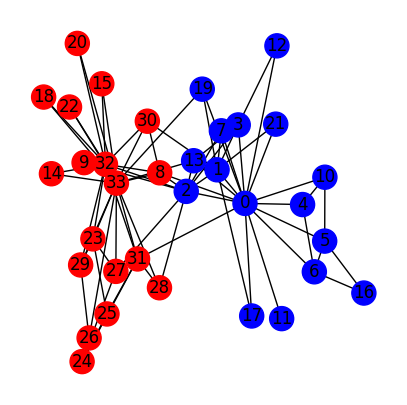

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21], [9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]]


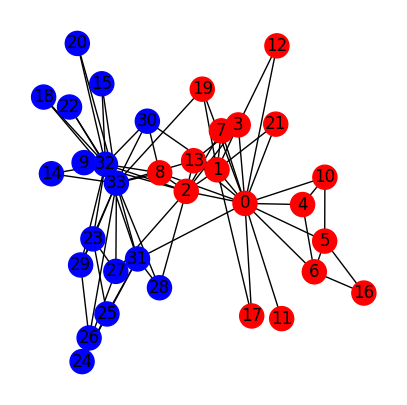

0.8371694628777809


In [4]:
N = G.number_of_nodes()
M = G.number_of_edges()
Np = 0
Nn = 0
#モジュラリティ行列B
A = np.array(nx.adjacency_matrix(G).todense())
k = np.sum(A, axis=0)
B = np.array([[A[i, j] - ((k[i] * k[j]) / (2 * M))  for j in range(N)] for i in range(N)])
#モジュラリティ行列 B の固有値,固有ベクトルを求める
values, vectors = np.linalg.eig(B)
values = np.array([i.real for i in values])
vectors = np.array([[vectors[i][j].real for j in range(N)]for i in range(N)])
#vectors = np.array([[0 if abs(vectors[i][j]) < 1e-10 else vectors[i][j]  for j in range(N)]for i in range(N)])
#values = np.array([0 if abs(i) < 1e-10 else i for i in values])
vectors = vectors.T
z = list(zip(values, vectors))
for i in values:
  if i < 0:
    Nn = Nn + 1
  if i > 0:
    Np = Np + 1
c = 1
#固有値の昇順に並べ替える
z = sorted(z, key=lambda x :x[0])  
values = [z[i][0] for i in range(len(z))]
vectors = np.array([list(z[i][1]) for i in range(N)])
Vp = np.array([list(z[i][1]) if z[i][0] > 0 else list(np.zeros(N)) for i in range(N-Np, N)]).T
Vn = np.array([list(z[i][1]) if z[i][0] < 0 else list(np.zeros(N)) for i in range(Nn)]).T
V = vectors.T
Lam = np.array([[values[i] if i == j else 0 for j in  range(N)] for i in range(N)])
Lamp = np.array([[Lam[i][j]**2 if (i == j) & (Lam[i][j] > 0) else 0 for j in  range(N-Np, N)] for i in range(N-Np, N)])
Lamn = np.array([[Lam[i][j]**2 if (i == j) & (Lam[i][j] < 0) else 0 for j in  range(Nn)] for i in range(Nn)])
Bp = Vp @ Lamp @ Vp.T
Bn = Vn @ Lamn @ Vn.T
squared_values = [(z[i][0])**2 for i in range(len(z))]


lam_1 = 0.5
lam_2 = 0.5
xk = np.zeros((Np, 1))
yk = np.zeros((Nn, 1))
#変数定義
s = cvxpy.Variable((N, 1))
x = cvxpy.Variable((Np, 1))
y = cvxpy.Variable((Nn, 1))
#問題定義
for i in range(50):
  obj = 0
  obj += xk.T @ Lamp @ (x - xk) + xk.T @ Lamp @ xk
  #obj -= yk.T @ Lamn @ (y - yk) + yk.T @ Lamn @ yk
  #obj += cvxpy.quad_form(y, Lamn)  #yT*Λn*y
  obj -= lam_1 * cvxpy.norm(s-1, p=1)
  obj -= lam_2 * cvxpy.norm(s+1, p=1)
  #print((-lam_1 * cvxpy.norm(s-1, p=1) - lam_2 * cvxpy.norm(s+1, p=1)).curvature)
  obj = cvxpy.Maximize(obj)
  constraints = [x == Vp.T @ s, -1 <= s , s<= 1]
  prob = cvxpy.Problem(obj, constraints)
  result = prob.solve()
  xk = x.value
  #結果表示
  #print('obj:', prob.value)
  #print('s:', s.value)
  s_value = s.value.reshape(N)
  #print(s_value)
 
group_1 = [i for i in range(G.number_of_nodes()) if s_value[i]>0]
group_2 = [i for i in range(G.number_of_nodes()) if s_value[i]<0]
s_label = np.zeros(N)
for i in range(N):
  for j in group_1:
    if j == i:
      s_label[i] =  1
  for j in group_2:
    if j == i:
      s_label[i] =  -1
#グラフの可視化
partition = [group_1, group_2]
print('ネットワーク分割結果：')
print(partition)
color_map = ['black'] * nx.number_of_nodes(G)
counter = 0
for c in partition :
  for n in c :
    color_map[n] = colors[counter]
  counter = counter + 1
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_nodes(G, pos, node_color=color_map)
nx.draw_networkx_labels(G, pos)
plt.axis('off')
plt.rcParams['figure.figsize'] = (5,5)
plt.show()
"""
pos = nx.spring_layout(G)
best_label = [1 if G.nodes[i]["block"]== 0 else -1 for i in G.nodes()]
"""
#空手クラブ
#頂点の属性は、「Officer」と「Mr. Hi」の属性を有している。
best_label = [1 if G.nodes[i]["club"]=="Officer" else -1 for i in G.nodes()]
group3 = []
group4 = []
for i in range(G.number_of_nodes()):
  if best_label[i] < 0:
    group3.append(i)
  else:
    group4.append(i)
partition1 = [group3, group4]
print(partition1)
#グラフの可視化
color_map1 = ['black'] * nx.number_of_nodes(G)
counter = 0
for c in partition1 :
  for n in c :
    color_map1[n] = colors[counter]
  counter = counter + 1
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_nodes(G, pos, node_color=color_map1)
nx.draw_networkx_labels(G, pos)
plt.axis('off')
plt.rcParams['figure.figsize'] = (5,5)
plt.show()
"""
#ベンチマーク
community = list({frozenset(G.nodes[v]["community"]) for v in G})
best_label = np.zeros(N)
for i in range(2):
  for j in list(community[i]):
    if i == 0:
      best_label[j] = -1
    if i == 1:
      best_label[j] = 1
print(best_label)
"""
#print(best_label)
nmi = normalized_mutual_info_score(best_label, s_label)
print(nmi)


In [ ]:
x = np.array(range(1, len(values)+1))
x2 = np.linspace(0, len(values)+1, 100)
print(values)
print(squared_values)
fig, ax = plt.subplots(constrained_layout=True) 
ax.scatter(x, values,  label='lam')
ax.scatter(x, squared_values, label='lam**2')
#ax.plot(x2, x2**2, '--', label='x**2')
ax.legend()

In [ ]:
N = G.number_of_nodes()
M = G.number_of_edges()
Np = 0
Nn = 0
#モジュラリティ行列B
A = np.array(nx.adjacency_matrix(G).todense())
k = np.sum(A, axis=0)
B = np.array([[A[i, j] - ((k[i] * k[j]) / (2 * M))  for j in range(N)] for i in range(N)])
#モジュラリティ行列 B の固有値,固有ベクトルを求める
values, vectors = np.linalg.eig(B)
values = np.array([i.real for i in values])
vectors = np.array([[vectors[i][j].real for j in range(N)]for i in range(N)])
vectors = np.array([[0 if abs(vectors[i][j]) < 1e-10 else vectors[i][j]  for j in range(N)]for i in range(N)])
values = np.array([0 if abs(i) < 1e-10 else i for i in values])
vectors = vectors.T
z = list(zip(values, vectors))
for i in values:
  if i < 0:
    Nn = Nn + 1
  if i > 0:
    Np = Np + 1
c = 1
#固有値の昇順に並べ替える
z = sorted(z, key=lambda x :x[0])  
values = [z[i][0] for i in range(len(z))]
vectors = np.array([list(z[i][1]) for i in range(N)])
Vp = np.array([list(z[i][1]) if z[i][0] > 0 else list(np.zeros(N)) for i in range(N-Np, N)]).T
Vn = np.array([list(z[i][1]) if z[i][0] < 0 else list(np.zeros(N)) for i in range(Nn)]).T
V = vectors.T
Lam = np.array([[values[i] if i == j else 0 for j in  range(N)] for i in range(N)])
Lamp = np.array([[Lam[i][j]**2 if (i == j) & (Lam[i][j] > 0) else 0 for j in  range(N-Np, N)] for i in range(N-Np, N)])
Lamn = np.array([[Lam[i][j]**2 if (i == j) & (Lam[i][j] < 0) else 0 for j in  range(Nn)] for i in range(Nn)])
Bp = Vp @ Lamp @ Vp.T
Bn = Vn @ Lamn @ Vn.T

lam_1 = 0.5
lam_2 = 0.5
xk = np.zeros((Np, 1))
yk = np.zeros((Nn, 1))
#変数定義
s = cvxpy.Variable((N, 1))
x = cvxpy.Variable((Np, 1))
y = cvxpy.Variable((Nn, 1))

obj = 0
obj += cvxpy.quad_form(x, Lamp)
obj -= cvxpy.quad_form(y, Lamn)  #yT*Λn*y
obj = cvxpy.Maximize(obj)
constraints = [x == Vp.T @ s ,y == Vn.T @ s, -1 <= s , s<= 1]
prob = cvxpy.Problem(obj, constraints)
result = prob.solve()
s_value = s.value.reshape(N)
print(s_value)
 

DCPError: ignored